#AKUSISI DATASET

In [1]:
!pip install kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [3]:
!kaggle datasets download "nicoletacilibiu/movies-and-ratings-for-recommendation-system"

Dataset URL: https://www.kaggle.com/datasets/nicoletacilibiu/movies-and-ratings-for-recommendation-system
License(s): CC0-1.0
  0% 0.00/846k [00:00<?, ?B/s]
100% 846k/846k [00:00<00:00, 696MB/s]


In [4]:
!unzip movies-and-ratings-for-recommendation-system.zip

Archive:  movies-and-ratings-for-recommendation-system.zip
  inflating: movies.csv              
  inflating: ratings.csv             


# DATA LOADING

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from tensorflow.keras import layers, ops
from tensorflow import keras
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors


In [6]:
df_movies = pd.read_csv("movies.csv")
df_ratings = pd.read_csv("ratings.csv")

# EDA

In [7]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [8]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [9]:
df_ratings['rating'].describe()

,rating
count,100836.000000
mean,3.501557
std,1.042529
min,0.500000
25%,3.000000
50%,3.500000
75%,4.000000
max,5.000000


In [10]:
# Menggabungkan data rating dan film menjadi satu.
df = df_movies.merge(df_ratings, on = 'movieId', how = "left")
df

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09
...,...,...,...,...,...,...
100849,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184.0,4.0,1.537109e+09
100850,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184.0,3.5,1.537110e+09
100851,193585,Flint (2017),Drama,184.0,3.5,1.537110e+09
100852,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184.0,3.5,1.537110e+09


In [11]:
df.isna().sum()

,0
movieId,0
title,0
genres,0
userId,18
rating,18
timestamp,18


In [12]:
rating_group = df.groupby(['title', 'rating']).size().reset_index(name='count')
rating_group = rating_group.sort_values(by='count', ascending=False)
rating_group.head(10)

,title,rating,count
23896,"Shawshank Redemption, The (1994)",5.0,153
21524,Pulp Fiction (1994),5.0,123
9956,Forrest Gump (1994),5.0,116
17188,"Matrix, The (1999)",5.0,109
25356,Star Wars: Episode IV - A New Hope (1977),5.0,104
24184,"Silence of the Lambs, The (1991)",4.0,97
14570,Jurassic Park (1993),4.0,97
9954,Forrest Gump (1994),4.0,94
23327,Schindler's List (1993),5.0,92
24186,"Silence of the Lambs, The (1991)",5.0,92


In [13]:
rating_group = df.groupby('title')['rating'].mean().sort_values(ascending=True).reset_index()

### Visualisasi

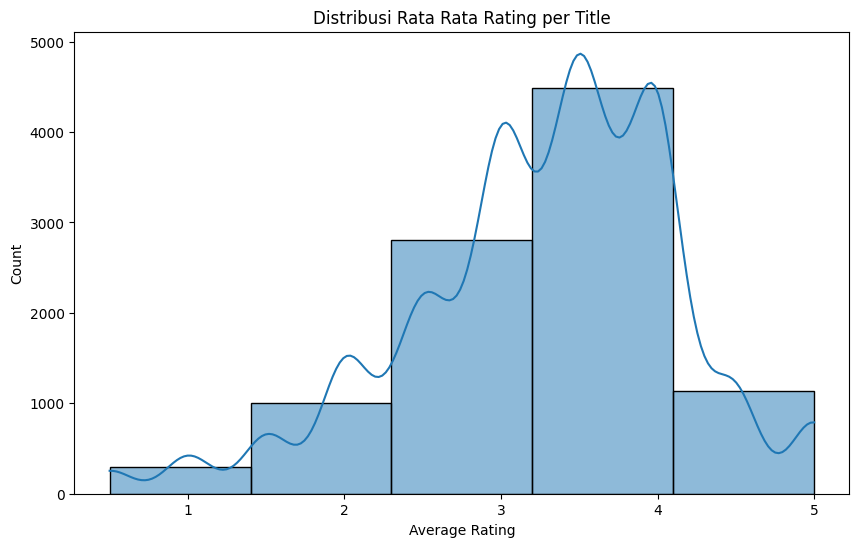

In [14]:
plt.figure(figsize=(10,6))
sns.histplot(rating_group['rating'], bins=5, kde=True)
plt.title('Distribusi Rata Rata Rating per Title')
plt.xlabel('Average Rating')
plt.show()

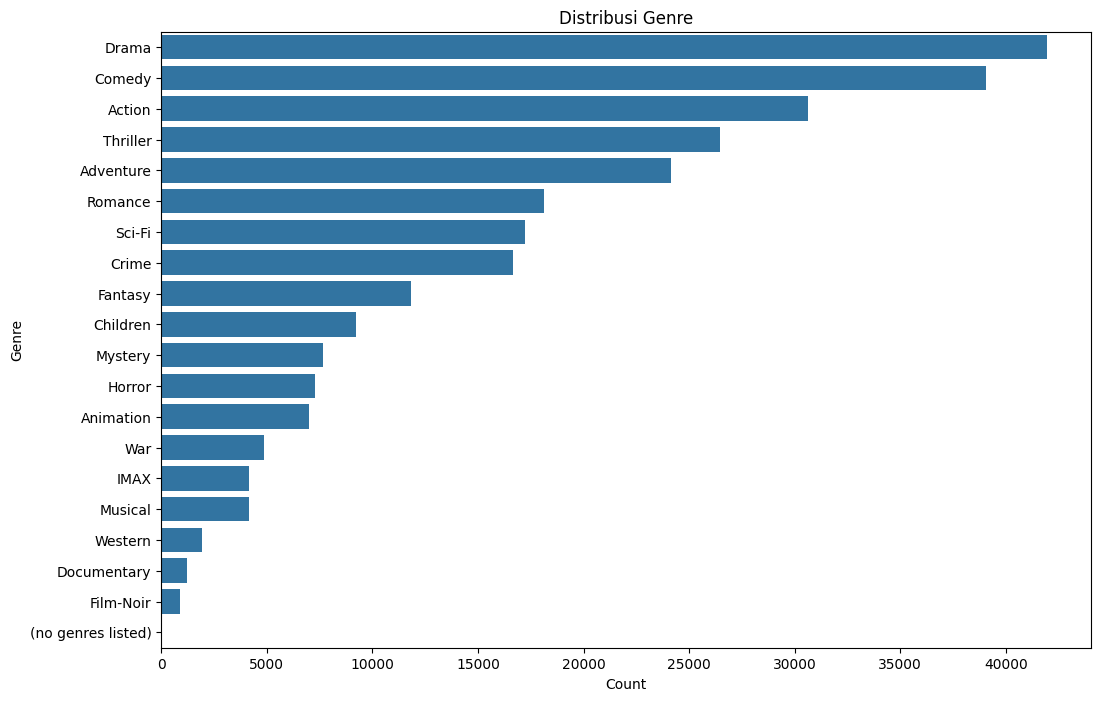

In [15]:
df_genres = df['genres'].str.split('|').explode()

genre_counts = df_genres.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title('Distribusi Genre')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()


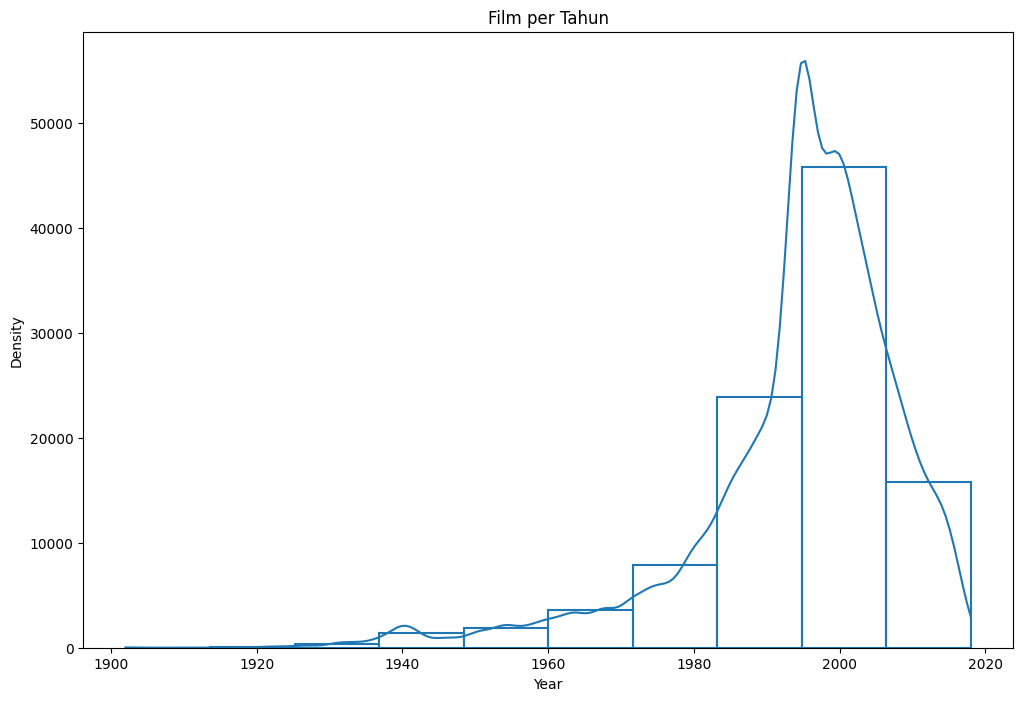

In [16]:
# Ekstrak tahun
df['year'] = df['title'].str.extract(r'\((\d{4})\)').astype(float)
plt.figure(figsize=(12,8))

# Hilangkan tahun yang hilang
years = df['year'].dropna()

# Plot histogram dengan KDE
sns.histplot(years, bins=10, kde=True, fill = False)

plt.title('Film per Tahun')
plt.xlabel('Year')
plt.ylabel('Density')
plt.show()

# Preprocessing

## Missing Value dan Duplicated

In [17]:
df.isna().sum()

,0
movieId,0
title,0
genres,0
userId,18
rating,18
timestamp,18
year,18


In [18]:
df = df.dropna()

In [19]:
print(df.duplicated().sum())

0


# Preparasi Untuk Content-Based Collaboration

## Embedding
Embed setiap genre dengan tfid

In [20]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['genres'])
tfidf_vectorizer.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'genres',
       'horror', 'imax', 'listed', 'musical', 'mystery', 'noir',
       'romance', 'sci', 'thriller', 'war', 'western'], dtype=object)

## Calculate Distance
Pengukuran kesamaan menggunakan cosinus

In [21]:
n_neighbors = 6
nn_model = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine', algorithm='brute')
nn_model.fit(tfidf_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=6)

In [22]:
distances, indices = nn_model.kneighbors(tfidf_matrix)
similarities = 1 - distances

## Preparasi Untuk Collaborative Learning

In [23]:
user_ids = df["userId"].unique().tolist()
movie_ids = df["movieId"].unique().tolist()

Melakukan encode agar lebih mudah dimasukkan ke model

In [24]:
user_idx = {x: i for i, x in enumerate(user_ids)}
movie_idx = {x: i for i, x in enumerate(movie_ids)}


movie_decoded = {i : x for i, x in enumerate(movie_ids)}  #mengubah kembali, untuk inferencing

df["userIdx"] = df["userId"].map(user_idx)
df["movieIdx"] = df["movieId"].map(movie_idx)

<ipython-input-24-98db5af0e3d9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["userIdx"] = df["userId"].map(user_idx)
<ipython-input-24-98db5af0e3d9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["movieIdx"] = df["movieId"].map(movie_idx)


In [25]:
df["rating"] = df["rating"].values.astype(np.float32) # konversi menjadi float

<ipython-input-25-f69e3d77b2f4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rating"] = df["rating"].values.astype(np.float32) # konversi menjadi float


In [26]:
#minmax scaling
min_rating = min(df["rating"])
max_rating = max(df["rating"])

# Mengambil jumlah user dan film
num_users = len(user_idx)
num_movies = len(movie_idx)

In [27]:
print('Lowest Rating | Max Rating: ', end = "")
print(min_rating,"|",max_rating)
print("Num Users | Num Movies: ", end = "")
print(num_users, "|",num_movies)

Lowest Rating | Max Rating: 0.5 | 5.0
Num Users | Num Movies: 610 | 9711


In [28]:
#Shuffle/Kocok dataset
df = df.sample(frac=1, random_state=42)
df

,movieId,title,genres,userId,rating,timestamp,year,userIdx,movieIdx
36719,1923,There's Something About Mary (1998),Comedy|Romance,263.0,4.0,9.403846e+08,1998.0,92,1403
40180,2134,Weird Science (1985),Comedy|Fantasy|Sci-Fi,387.0,2.5,1.095041e+09,1985.0,336,1591
49900,2959,Fight Club (1999),Action|Crime|Drama|Thriller,211.0,5.0,1.350913e+09,1999.0,468,2224
6187,230,Dolores Claiborne (1995),Drama|Thriller,414.0,3.0,9.615180e+08,1995.0,146,196
12080,434,Cliffhanger (1993),Action|Adventure|Thriller,353.0,3.0,8.319397e+08,1993.0,127,378
...,...,...,...,...,...,...,...,...,...
6265,231,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy,353.0,4.0,8.319397e+08,1994.0,127,197
54890,3499,Misery (1990),Drama|Horror|Thriller,599.0,2.5,1.498515e+09,1990.0,204,2610
76830,8670,"Testament of Dr. Mabuse, The (Das Testament de...",Crime|Horror|Mystery|Thriller,387.0,4.0,1.179200e+09,1933.0,336,5262
860,15,Cutthroat Island (1995),Action|Adventure|Romance,6.0,4.0,8.455545e+08,1995.0,215,14


In [29]:
x = df[["userIdx", "movieIdx"]].values
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

In [30]:
#Splice dataste
split = int(0.9 * df.shape[0])
x_train, x_val, x_test, y_train, y_val, y_test = (x[:split], x[split:], x[:split], y[:split], y[split:], y[split:])

# Training

# Content Based / System

In [31]:
def recommend(movie_index, df, indices, similarities):
    print(f"Original Movie: {df.iloc[movie_index]['title']} {df.iloc[movie_index]['genres']}\n")
    print("Top Recommendations:")
    amt_recommend = len(indices[movie_index])
    sims = similarities[movie_index]
    rec_df = pd.DataFrame(columns=['idx', 'movie_id', 'title', 'genres', 'rating', 'similarity Score'])
    for i in range(1, amt_recommend): #Loop hingga jumlah yang di klasifikasikan sesuai pada jumlah film yang di dapatkan di similarity index similarity test
        idx = indices[movie_index][i]
        movie_id = df.iloc[idx]['movieId']
        title = df.iloc[idx]['title']
        rating = df.iloc[idx]['rating']
        genre = df.iloc[idx]['genres']
        similarity_score = similarities[movie_index][i]
        rec_df.loc[i] = [idx, movie_id, title, genre, rating, similarity_score]

    return rec_df

In [42]:
def calculate_precision(movie_index, df, indices, top_n_recommendations=10):
    # Ambil genre
    target_genres = set(df.loc[movie_index, 'genres'].split('|'))

    # Ambil nilai neighbors
    neighbor_indices = indices[movie_index][1:top_n_recommendations + 1]

    # Hmenghitung berapa banyak rekomendasi film yang memiliki kemiripan genre dengan film target.
    relevant_count = 0
    for i in neighbor_indices:
        candidate_genres = set(df.loc[i, 'genres'].split('|'))
        if target_genres & candidate_genres:
            relevant_count += 1

    precision = relevant_count / top_n_recommendations
    return precision


## Melakukan Percobaan atau Inferencing
Di tahapan ini, system yang di bangun akan di test.

In [33]:
x = recommend(123, df, indices, similarities)
x

Original Movie: Untouchables, The (1987) Action|Crime|Drama

Top Recommendations:


,idx,movie_id,title,genres,rating,similarity Score
1,64064,31658,Howl's Moving Castle (Hauru no ugoku shiro) (2...,Adventure|Animation|Fantasy|Romance,4.0,1.0
2,64065,2064,Roger & Me (1989),Documentary,5.0,1.0
3,64034,2421,"Karate Kid, Part II, The (1986)",Action|Adventure|Drama,2.0,1.0
4,64035,92535,Louis C.K.: Live at the Beacon Theater (2011),Comedy,4.5,1.0
5,64036,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi,3.5,1.0


In [44]:
precision = calculate_precision(
    movie_index=123,
    df=df,
    indices=indices,
    top_n_recommendations=5
)

print(f"Genre-based Precision@5 untuk index 123: {precision:.2f}")


Genre-based Precision@5 untuk index 123: 1.00


Dalam percoaan ini, kita mendapat 4 film yang direkomendasikan.


Bila diperhatikan, seluruh film ini tidak memiliki hubungan langsung dengan film Untouchables, ini merupakan nilai yang diekspektasikan karena ketika menggunakan tfidf, yang diperhatikan hanyalaah hubungan 1 kalimat ke kalimat yang lain.

# Collaborative Filtering

Membangun custom model menggunakan keras.

In [35]:
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users #berapa banyak user?
        self.num_movies = num_movies #berapa banyak film?
        self.embedding_size = embedding_size #Seberapa besar embedding akan dilakukan?
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        ) #melakukan embedding terhadap user menjadi nilai vector
        self.user_bias = layers.Embedding(num_users, 1) #menambah bias untuk nilai user
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        ) #melakukan embedding terhadap film menjadi nilai vektor
        self.movie_bias = layers.Embedding(num_movies, 1) #menentukan bias untuk film

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        # Mencari dot products melalui perkalian matriks
        dot_user_movie = ops.tensordot(user_vector, movie_vector, 2)
        # kemudian menambah bias
        x = dot_user_movie + user_bias + movie_bias
        # Hitung nilai aktivasinya
        return ops.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, 50)
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
)


In [36]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=15,
    verbose=1,
    validation_data=(x_val, y_val),
)


Epoch 1/15
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 58s 20ms/step - loss: 0.6526 - val_loss: 0.6154
Epoch 2/15
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 59s 12ms/step - loss: 0.6123 - val_loss: 0.6096
Epoch 3/15
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - loss: 0.6090 - val_loss: 0.6071
Epoch 4/15
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - loss: 0.6043 - val_loss: 0.6062
Epoch 5/15
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - loss: 0.6033 - val_loss: 0.6057
Epoch 6/15
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 48s 12ms/step - loss: 0.6016 - val_loss: 0.6068
Epoch 7/15
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 54s 17ms/step - loss: 0.6030 - val_loss: 0.6061
Epoch 8/15
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 61s 9ms/step - loss: 0.6000 - val_loss: 0.6064
Epoch 9/15
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 0.6010 - val_loss: 0.6052
Epoch 10/15
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 0.6004 - val_loss: 0.6050
Epoch 11/15
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - loss: 0.6006 - val_loss: 0.6061
Epoch 12/15


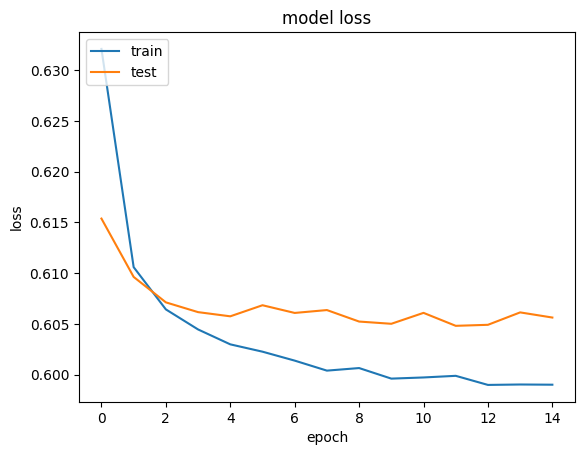

In [37]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# **Inferencing**

In [38]:
# Mengambil Data User secara acak
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = df_movies[~df_movies["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]
movies_not_watched = list(set(movies_not_watched).intersection(set(movie_idx.keys())))
movies_not_watched = [[movie_idx.get(x)] for x in movies_not_watched]
user_encoder = user_idx.get(user_id)
user_movie_array = np.hstack(([[user_encoder]] * len(movies_not_watched), movies_not_watched))

In [39]:
print(f"id: {user_id}")
movies_watched_by_user[movies_watched_by_user['rating'] >= 4].sample(5)

id: 524.0


,movieId,title,genres,userId,rating,timestamp,year,userIdx,movieIdx
27116,1231,"Right Stuff, The (1983)",Drama,524.0,4.0,851609597.0,1983.0,179,930
29439,1291,Indiana Jones and the Last Crusade (1989),Action|Adventure,524.0,5.0,851609392.0,1989.0,179,989
4223,150,Apollo 13 (1995),Adventure|Drama|IMAX,524.0,5.0,851608745.0,1995.0,179,123
25833,1208,Apocalypse Now (1979),Action|Drama|War,524.0,4.0,851609788.0,1979.0,179,908
18226,733,"Rock, The (1996)",Action|Adventure|Thriller,524.0,4.0,852404489.0,1996.0,179,592


Bila diperhaitkan, film yang di sukai oleh pengguna 599 adalah yang bersifat drama, dan thriller/mysteries, dengan mayoritasnya adalah Drama.

In [40]:
ratings = model.predict(user_movie_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1] #mengambil rekomendasi 10 film terbaik
recommended_movie_ids = [
    movie_decoded.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("User Sample: {}".format(user_id))
print("====" * 9)
print("Film dengan penilaian tinggi dri user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
) #mengambil 5 film dengan rating terbaik yang diberikan user
movie_df_rows = df_movies[df_movies["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("10 rekomendasi film yang akan di ambil")
print("----" * 8)
recommended_movies = df_movies[df_movies["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
User Sample: 524.0
Film dengan penilaian tinggi dri user
--------------------------------
Apollo 13 (1995) : Adventure|Drama|IMAX
Rob Roy (1995) : Action|Drama|Romance|War
Star Wars: Episode IV - A New Hope (1977) : Action|Adventure|Sci-Fi
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Indiana Jones and the Last Crusade (1989) : Action|Adventure
--------------------------------
10 rekomendasi film yang akan di ambil
--------------------------------
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950) : Drama|Film-Noir|Romance
Notorious (1946) : Film-Noir|Romance|Thriller
To Catch a Thief (1955) : Crime|Mystery|Romance|Thriller
His Girl Friday (1940) : Comedy|Romance
It's a Wonderful Life (1946) : Children|Drama|Fantasy|Romance
Top Secret! (1984) : Comedy
Trial, The (Procès, Le) (1962) : Drama
DiG! (2004) : Documentary
Captain Fantastic (2016) : Drama
Three Billboards Outside Ebbing, Missouri (2017) : Crime|Drama


Kita mendapat film yang mayoritasnya drama melalui sistem rekomendasi yang telah dibaut